In [19]:
#https://medium.com/raposa-technologies/how-to-build-your-first-mean-reversion-trading-strategy-in-python-8c9d4813ee40
#https://medium.com/raposa-technologies/backtest-your-first-strategy-in-python-88f663aee95e

import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date


import re
import time
import stat
import contextlib
import functools

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

#from fbprophet import Prophet
import urllib
import urllib.request
import pandas_market_calendars as mcal
import os.path
from os import path
from functools import reduce
#import pandas-datareader
#import mpl-finance
#from fbprophet.diagnostics import cross_validation
#rom fbprophet import Prophet
import stockstats
from stockstats import StockDataFrame
import tabulate
import mplfinance as mpf
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc

import os.path
from os import path

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

from finta import TA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_ind

In [89]:
n_forward = 1

benchName = "^GSPC"
bench = yf.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date
benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)


w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)

#- timedelta(weeks=w*2)
start_date = end_date1 - timedelta(weeks=w)

dateindex = benchData.loc[start_date:end_date].index
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+5))-start_date).days)]


#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

nyse = mcal.get_calendar('NYSE')

nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+3)))

#if(len(data)==len(dateindex_)):
if(len(benchData)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0)
    frequency = pd.to_datetime(frequency, errors='coerce',format='%Y-%m-%d').index
    
else:
    frequency=nyse_trading_dates.rename_axis([None]).index
    
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)
df = df.interpolate(method='linear')
benchData = df[start_date:end_date]


In [90]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

In [91]:
pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

one_week_end = start_date
one_week_start = one_week_end - timedelta(weeks=1)

#need to do the two pass trick (i.e. find stocks fully populated a week 9 quarters back)

nyse = mcal.get_calendar('NYSE')
official_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date)

date_time_obj_start = start_date

date_time_obj_end = end_date

one_week_trading_dates = nyse.schedule(start_date=one_week_start, end_date=one_week_end)

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

#should turn this into a function
if path.exists("nasdaqtraded.txt"):
    print("file exists")
    
    filePath = 'nasdaqtraded.txt'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading")
        urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
        urllib.request.urlretrieve(url, 'mfundslist.txt')
        urllib.request.urlretrieve(url, 'bonds.txt')
    else:
      print("equal dates, not redownloading")
    
else:
    print("downloading nasdaqtraded.txt")
    urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
    urllib.request.urlretrieve(url, 'mfundslist.txt')
    urllib.request.urlretrieve(url, 'bonds.txt')
    
df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#process symbols for bad characters
BAD_CHARS = ['$','.']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df1 = df1[~df1['Symbol'].str.contains(pat)]
df2 = df2[~df2['Symbol'].str.contains(pat)]
df3 = df3[~df3['Symbol'].str.contains(pat)]

#choose size
size=100
#stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(df1["Symbol"].sample(n=int(size)))
mfunds = list(df2["Symbol"].sample(n=int(size/3)))
bonds = list(df3["Symbol"].sample(n=int(size/3)))
#symbols = unique(stocks + mfunds + bonds)
symbols = unique(stocks)

def dl_one_week(stock):
    subset = yf.download(stock, start=one_week_start, end=one_week_end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[one_week_start.strftime('%Y-%m-%d'):one_week_end.strftime('%Y-%m-%d')]
    if len(subset) != 0:
        return (subset)

def dl(stock):
    subset = yf.download(stock, start=start_date, end=end_date+timedelta(days=1), auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    subset2 = subset[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)

def processStocks(symbols):

    futures1 = [pool1.submit(dl_one_week, args) for args in symbols]
    wait(futures1, timeout=None, return_when=ALL_COMPLETED)

    symbols_data_one_week = pd.DataFrame()

    for x in range(0,len(symbols)):
        prices = pd.DataFrame(futures1[x].result())
        prices['Symbol'] = symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        symbols_data_one_week = pd.concat([symbols_data_one_week,prices])

    #symbols_data_one_week

    #stocks that existed 9 quarters ago
    vetted_symbols = list(symbols_data_one_week.Symbol.unique())

    pool2 = concurrent.futures.ProcessPoolExecutor(cores)

    futures2 = [pool2.submit(dl, args) for args in vetted_symbols]
    wait(futures2, timeout=None, return_when=ALL_COMPLETED)    

    symbols_data = pd.DataFrame()
    
    #Have to interpolate later
    for x in range(0,len(vetted_symbols)):
        prices = pd.DataFrame(futures2[x].result())
        prices['Symbol'] = vetted_symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        #idx1 = prices.index  
        
        #df = prices.rename_axis([None]).reindex(frequency)

        #for d in prices.rename_axis([None]).index:
            #df.loc[d] = prices.loc[d]

        #df.interpolate(method='linear')
        
        #merged = idx1.union(frequency)
        #s = prices.reindex(merged)
        #df = s.interpolate().dropna(axis=0, how='any')

        #if len(df) == len(prices.index):
        symbols_data = pd.concat([symbols_data,prices])
            
    symbols_data.to_csv('symbols_data.csv', index = False)

if path.exists('symbols_data.csv'):
    print("data exists")
    
    filePath = 'symbols_data.csv'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading stocks")
        
        processStocks(symbols)
        
    else:
        print("equal dates, not redownloading")
    
else:
    print("downloading symbols")
    processStocks(symbols)
    


file exists
Last Modified Time :  Thu May 27 21:21:08 2021
not same dates downloading
data exists
Last Modified Time :  Thu May 27 21:22:50 2021
not same dates downloading stocks


/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
1 Failed download:
- CHAA: Data doesn't exist for startDate = 1480050000, endDate = 1480654800


- ACIO: Data doesn't exist for startDate = 1480050000, endDate = 1480654800
1 Failed download:

- DGNS: Data doesn't exist for startDate = 1480050000, endDate = 1480654800
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1 Failed download:

- GO: Data doesn't exist for startDate = 1480050000, endDate = 1480654800
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 comple

In [92]:
#symbols = ['BTC-USD']
#processStocks(symbols)

symbols_data = pd.read_csv('symbols_data.csv', sep=',')[0:-1]
vetted_symbols = symbols_data.Symbol.unique()


In [93]:
returnsdf = pd.DataFrame()
returnsl = []

#cumulative returns of 1st half
for i in vetted_symbols:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    #plt.plot(cumulative_ret, label=i)
    #plt.legend(loc="upper left",fontsize=8)
    
returnsdf["returns"] = returnsl
returnsdf["stock"] = vetted_symbols

returnsdf = returnsdf.sort_values(by=['returns'], ascending=False)

XPercent = .1
cutoff = round(len(returnsdf)*XPercent,0)

topXPercent = returnsdf['stock'][0:int(cutoff)]
topXPercent

52    GBOX
7      GOL
24    STAA
43    XXII
15     SCR
46     PTC
Name: stock, dtype: object

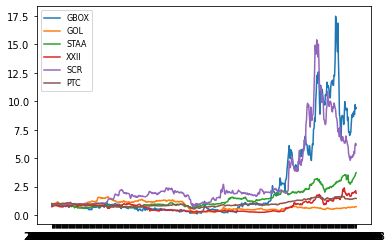

In [94]:
#cumulative returns over test period

for i in topXPercent:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    plt.plot(cumulative_ret, label=i)
    plt.legend(loc="upper left",fontsize=8)
    #plt.xticks(rotation=30) 

(array([17987., 18078., 18170., 18262., 18353., 18444., 18536., 18628.,
        18718., 18809.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

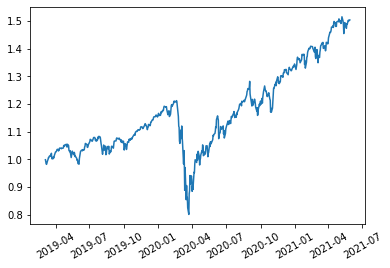

In [95]:
limit = 100

train_size = 0.5

#minExpectedReturn = 0.0005
minExpectedReturn = 0.0

#width1 = len(nyse_trading_dates[start_date:end_date1].index)

#not doing any sales here, so is the +1 necessary?
#even if doing +1 I don't want to use timedelta, but it's okay to use it becuase at most it's +1 actual day (vs trading day) and the filtering will still work
#width2 = len(data.loc[end_date1+timedelta(days=1):end_date].index)
width2 = len(nyse_trading_dates[end_date1+timedelta(days=1):end_date].index)


#dateindex = benchData.loc[start_date:end_date].index
#returnsdf[0:int(cutoff)]

dateindex = benchData.loc[start_date:end_date].index
dateindex_ = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date)-start_date).days)]
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

sp500_data = benchData[end_date1+timedelta(days=1):end_date]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.xticks(rotation=30) 

array([  1,   3,   1,   1,   1,   1,   3,   1,   1,  28,   1,   1,   5,
         2,   3,   4,   5, 224, 462])

In [111]:
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, 
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    #print(data)
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    
    return stats_dict

def SMABacktest(ticker, short_term_sma, long_term_sma, 
    shorts=False, start_date=end_date1.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d')):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    
    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, 0)
    
    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(
        data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data

def SMAMeanReversionSafety(ticker, sma, threshold, safety_threshold=0.25, shorts=False,
    start_date=end_date1.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d')):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * \
        data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = \
        np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()


In [97]:
topXPercent

52    GBOX
7      GOL
24    STAA
43    XXII
15     SCR
46     PTC
Name: stock, dtype: object

In [98]:
'''
for symbol in topXPercent[[1]]:
    subset = symbols_data[symbols_data["Symbol"]==symbol].dropna().copy()    
    
    #print(subset)
    #subset = subset.set_index('Date')
    print(subset)
'''

'\nfor symbol in topXPercent[[1]]:\n    subset = symbols_data[symbols_data["Symbol"]==symbol].dropna().copy()    \n    \n    #print(subset)\n    #subset = subset.set_index(\'Date\')\n    print(subset)\n'

GBOX


,A,A Buy and Hold,SMA,base_strat
tot_returns,8.316,8.833,0.206,0.421
annual_returns,1.706,1.772,0.087,0.170
annual_volatility,0.967,2.341,0.312,0.433
sharpe_ratio,1.743,0.748,0.215,0.346
max_drawdown,10.763,11.361,0.483,0.571
max_drawdown_duration,51.000,262.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,1464.252,10.800,1464.252,10.800
annual_returns,25.431,2.030,25.431,2.030
annual_volatility,2.157,2.338,2.157,2.338
sharpe_ratio,11.780,0.860,11.780,0.860
max_drawdown,6814.763,11.361,6814.763,11.361
max_drawdown_duration,267.000,262.000,267.000,262.000


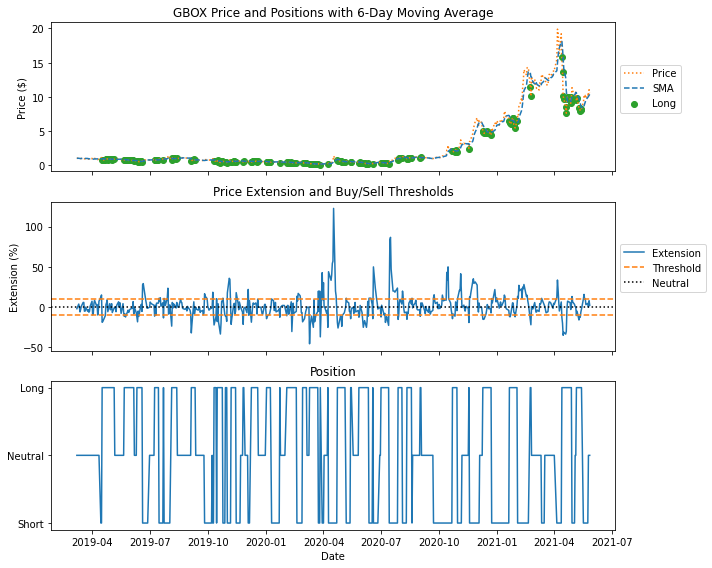

,A,A Buy and Hold,SMA,base_strat
tot_returns,8.316,8.833,8.316,8.833
annual_returns,1.706,1.772,1.706,1.772
annual_volatility,0.967,2.341,0.967,2.341
sharpe_ratio,1.743,0.748,1.743,0.748
max_drawdown,10.763,11.361,10.763,11.361
max_drawdown_duration,51.000,262.000,51.000,262.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,7.825,8.833,7.825,8.833,7.825,8.833
annual_returns,1.641,1.772,1.641,1.772,1.641,1.772
annual_volatility,2.341,2.341,2.341,2.341,2.341,2.341
sharpe_ratio,0.693,0.748,0.693,0.748,0.693,0.748
max_drawdown,10.197,11.361,10.197,11.361,10.197,11.361
max_drawdown_duration,320.000,262.000,320.000,262.000,320.000,262.000


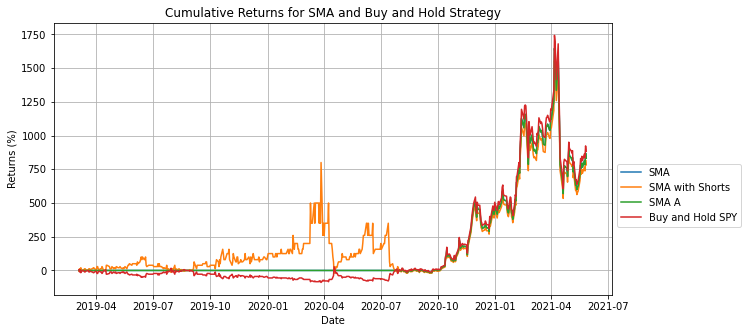

GOL


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.140,-0.255,0.206,0.421
annual_returns,-0.065,-0.123,0.087,0.170
annual_volatility,0.330,0.967,0.312,0.433
sharpe_ratio,-0.258,-0.148,0.215,0.346
max_drawdown,0.505,1.460,0.483,0.571
max_drawdown_duration,490.000,665.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.834,-0.253,-0.834,-0.253
annual_returns,-0.554,-0.123,-0.554,-0.123
annual_volatility,0.777,0.970,0.777,0.970
sharpe_ratio,-0.738,-0.147,-0.738,-0.147
max_drawdown,1.100,1.460,1.100,1.460
max_drawdown_duration,734.000,665.000,734.000,665.000


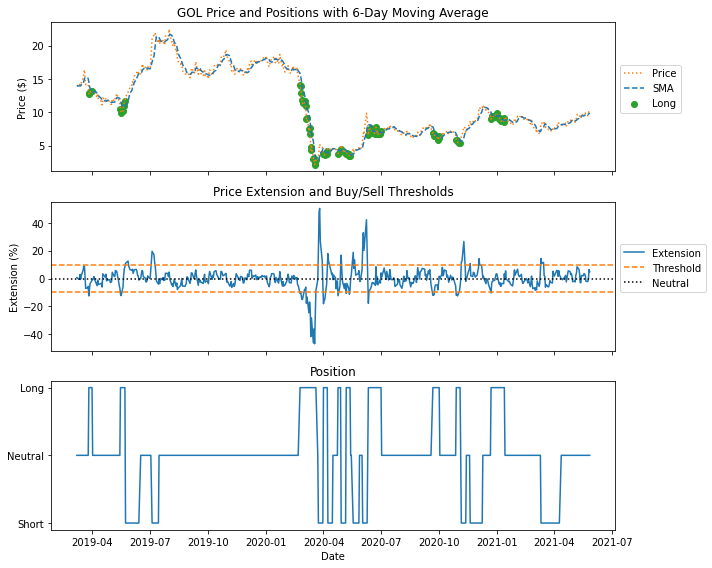

,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.140,-0.255,-0.140,-0.255
annual_returns,-0.065,-0.123,-0.065,-0.123
annual_volatility,0.330,0.967,0.330,0.967
sharpe_ratio,-0.258,-0.148,-0.258,-0.148
max_drawdown,0.505,1.460,0.505,1.460
max_drawdown_duration,490.000,665.000,490.000,665.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,-0.008,-0.255,-0.008,-0.255,-0.008,-0.255
annual_returns,-0.003,-0.123,-0.003,-0.123,-0.003,-0.123
annual_volatility,0.967,0.967,0.967,0.967,0.967,0.967
sharpe_ratio,-0.024,-0.148,-0.024,-0.148,-0.024,-0.148
max_drawdown,2.361,1.460,2.361,1.460,2.361,1.460
max_drawdown_duration,435.000,665.000,435.000,665.000,435.000,665.000


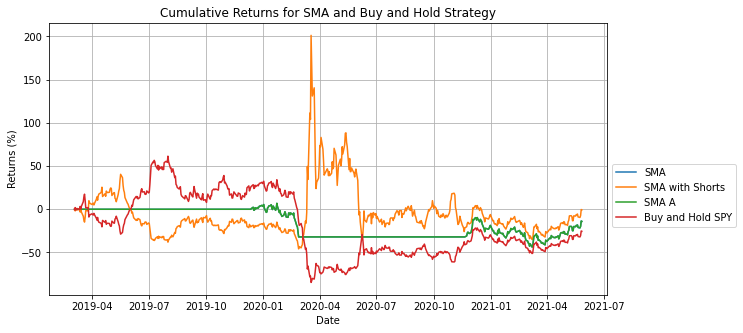

STAA


,A,A Buy and Hold,SMA,base_strat
tot_returns,1.902,2.514,0.206,0.421
annual_returns,0.608,0.752,0.087,0.170
annual_volatility,0.488,0.594,0.312,0.433
sharpe_ratio,1.205,1.231,0.215,0.346
max_drawdown,0.961,1.164,0.483,0.571
max_drawdown_duration,157.000,299.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.075,2.876,-0.075,2.876
annual_returns,-0.035,0.838,-0.035,0.838
annual_volatility,0.308,0.595,0.308,0.595
sharpe_ratio,-0.177,1.375,-0.177,1.375
max_drawdown,0.400,1.164,0.400,1.164
max_drawdown_duration,419.000,299.000,419.000,299.000


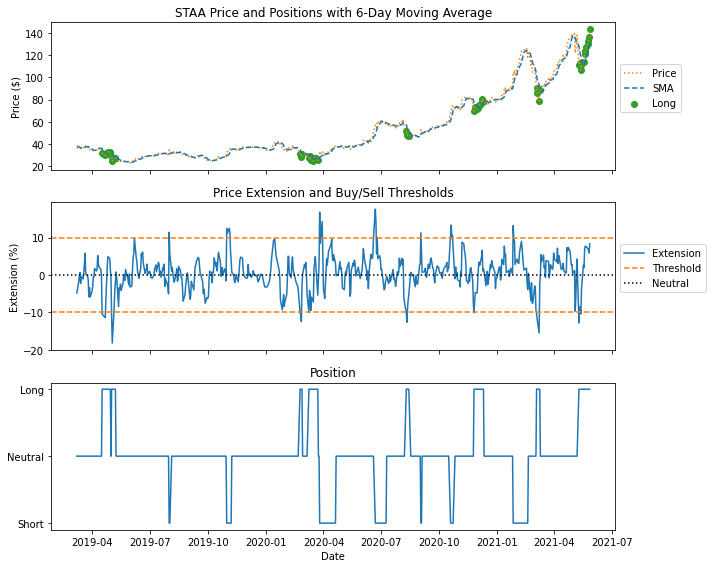

,A,A Buy and Hold,SMA,base_strat
tot_returns,1.902,2.514,1.902,2.514
annual_returns,0.608,0.752,0.608,0.752
annual_volatility,0.488,0.594,0.488,0.594
sharpe_ratio,1.205,1.231,1.205,1.231
max_drawdown,0.961,1.164,0.961,1.164
max_drawdown_duration,157.000,299.000,157.000,299.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,1.397,2.514,1.397,2.514,1.397,2.514
annual_returns,0.477,0.752,0.477,0.752,0.477,0.752
annual_volatility,0.595,0.594,0.595,0.594,0.595,0.594
sharpe_ratio,0.768,1.231,0.768,1.231,0.768,1.231
max_drawdown,1.173,1.164,1.173,1.164,1.173,1.164
max_drawdown_duration,605.000,299.000,605.000,299.000,605.000,299.000


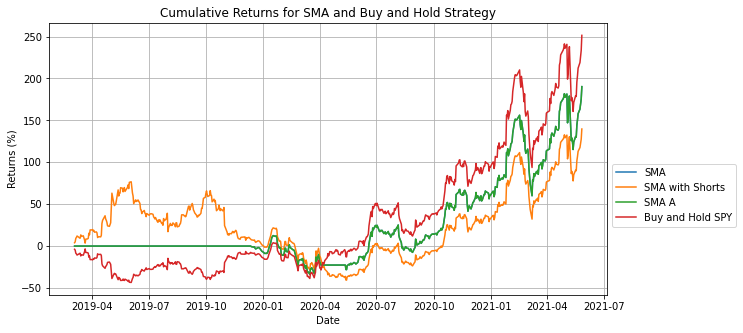

XXII


,A,A Buy and Hold,SMA,base_strat
tot_returns,2.741,1.167,0.206,0.421
annual_returns,0.801,0.412,0.087,0.170
annual_volatility,0.559,1.018,0.312,0.433
sharpe_ratio,1.397,0.385,0.215,0.346
max_drawdown,1.548,0.897,0.483,0.571
max_drawdown_duration,60.000,441.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.419,1.806,-0.419,1.806
annual_returns,-0.216,0.589,-0.216,0.589
annual_volatility,0.747,0.999,0.747,0.999
sharpe_ratio,-0.316,0.570,-0.316,0.570
max_drawdown,2.416,0.897,2.416,0.897
max_drawdown_duration,275.000,441.000,275.000,441.000


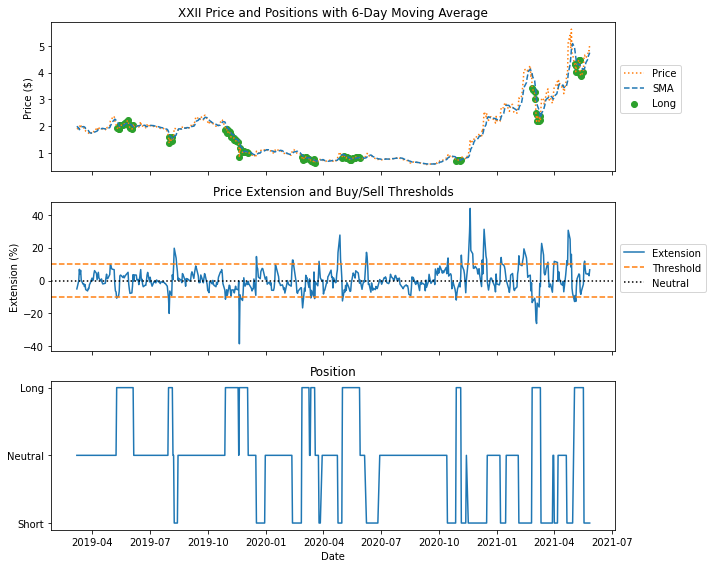

,A,A Buy and Hold,SMA,base_strat
tot_returns,2.741,1.167,2.741,1.167
annual_returns,0.801,0.412,0.801,0.412
annual_volatility,0.559,1.018,0.559,1.018
sharpe_ratio,1.397,0.385,1.397,0.385
max_drawdown,1.548,0.897,1.548,0.897
max_drawdown_duration,60.000,441.000,60.000,441.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,5.456,1.167,5.456,1.167,5.456,1.167
annual_returns,1.298,0.412,1.298,0.412,1.298,0.412
annual_volatility,1.017,1.018,1.017,1.018,1.017,1.018
sharpe_ratio,1.256,0.385,1.256,0.385,1.256,0.385
max_drawdown,2.672,0.897,2.672,0.897,2.672,0.897
max_drawdown_duration,152.000,441.000,152.000,441.000,152.000,441.000


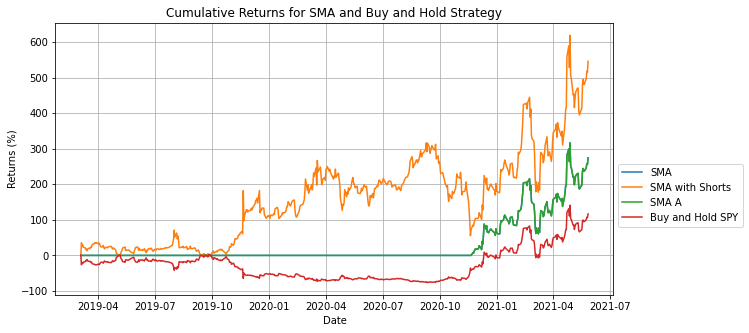

SCR


,A,A Buy and Hold,SMA,base_strat
tot_returns,0.638,5.232,0.206,0.421
annual_returns,0.246,1.262,0.087,0.170
annual_volatility,0.882,1.020,0.312,0.433
sharpe_ratio,0.257,1.217,0.215,0.346
max_drawdown,2.751,10.464,0.483,0.571
max_drawdown_duration,329.000,172.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.812,5.667,-0.812,5.667
annual_returns,-0.528,1.345,-0.528,1.345
annual_volatility,0.805,1.023,0.805,1.023
sharpe_ratio,-0.680,1.295,-0.680,1.295
max_drawdown,0.827,10.464,0.827,10.464
max_drawdown_duration,665.000,172.000,665.000,172.000


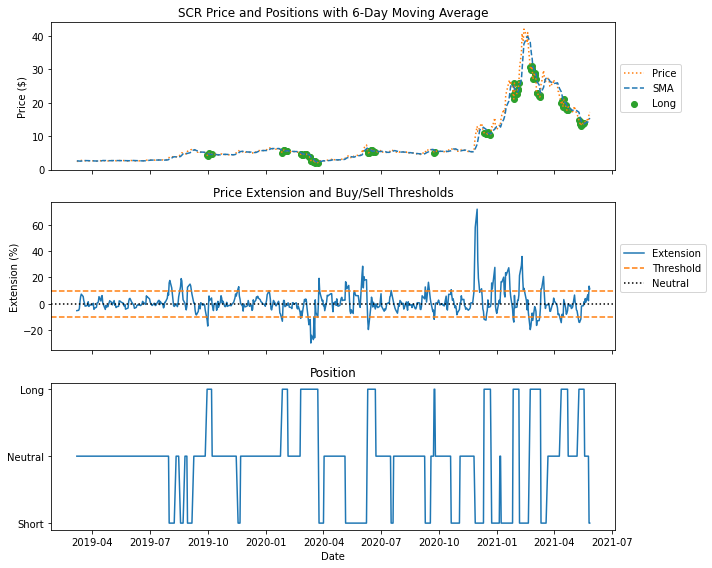

,A,A Buy and Hold,SMA,base_strat
tot_returns,0.638,5.232,0.638,5.232
annual_returns,0.246,1.262,0.246,1.262
annual_volatility,0.882,1.020,0.882,1.020
sharpe_ratio,0.257,1.217,0.257,1.217
max_drawdown,2.751,10.464,2.751,10.464
max_drawdown_duration,329.000,172.000,329.000,172.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,-0.569,5.232,-0.569,5.232,-0.569,5.232
annual_returns,-0.313,1.262,-0.313,1.262,-0.313,1.262
annual_volatility,1.021,1.020,1.021,1.020,1.021,1.020
sharpe_ratio,-0.326,1.217,-0.326,1.217,-0.326,1.217
max_drawdown,1.038,10.464,1.038,10.464,1.038,10.464
max_drawdown_duration,807.000,172.000,807.000,172.000,807.000,172.000


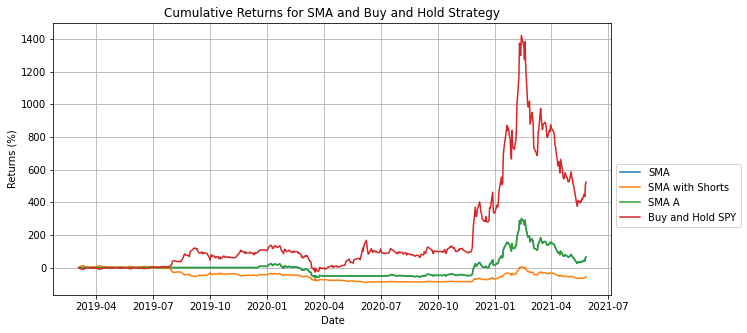

PTC


,A,A Buy and Hold,SMA,base_strat
tot_returns,0.206,0.421,0.206,0.421
annual_returns,0.087,0.170,0.087,0.170
annual_volatility,0.312,0.433,0.312,0.433
sharpe_ratio,0.215,0.346,0.215,0.346
max_drawdown,0.483,0.571,0.483,0.571
max_drawdown_duration,300.000,579.000,300.000,579.000


,A,A Buy and Hold,SMA,base_strat
tot_returns,-0.193,0.484,-0.193,0.484
annual_returns,-0.092,0.194,-0.092,0.194
annual_volatility,0.180,0.434,0.180,0.434
sharpe_ratio,-0.623,0.401,-0.623,0.401
max_drawdown,0.273,0.571,0.273,0.571
max_drawdown_duration,671.000,579.000,671.000,579.000


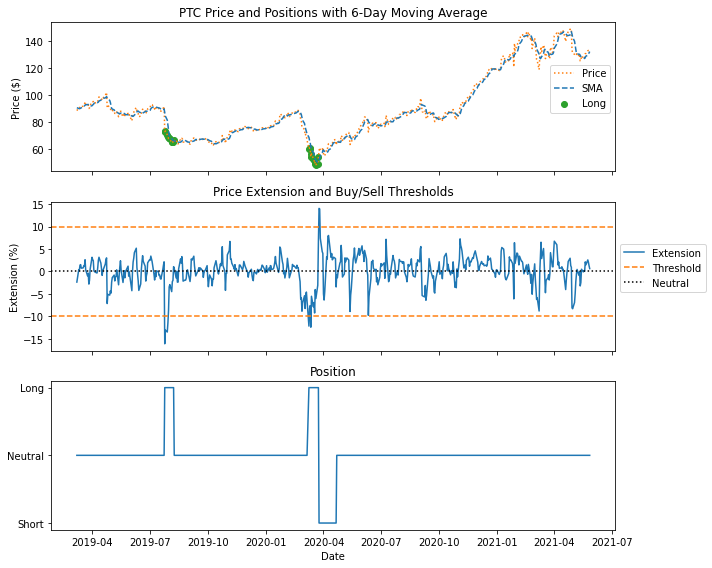

,A,A Buy and Hold,SMA,base_strat
tot_returns,0.206,0.421,0.206,0.421
annual_returns,0.087,0.170,0.087,0.170
annual_volatility,0.312,0.433,0.312,0.433
sharpe_ratio,0.215,0.346,0.215,0.346
max_drawdown,0.483,0.571,0.483,0.571
max_drawdown_duration,300.000,579.000,300.000,579.000


,A,A Buy and Hold,SMA with Shorts,Buy and Hold,SMA with Shorts,Buy and Hold
tot_returns,0.022,0.421,0.022,0.421,0.022,0.421
annual_returns,0.010,0.170,0.010,0.170,0.010,0.170
annual_volatility,0.433,0.433,0.433,0.433,0.433,0.433
sharpe_ratio,-0.023,0.346,-0.023,0.346,-0.023,0.346
max_drawdown,0.924,0.571,0.924,0.571,0.924,0.571
max_drawdown_duration,597.000,579.000,597.000,579.000,597.000,579.000


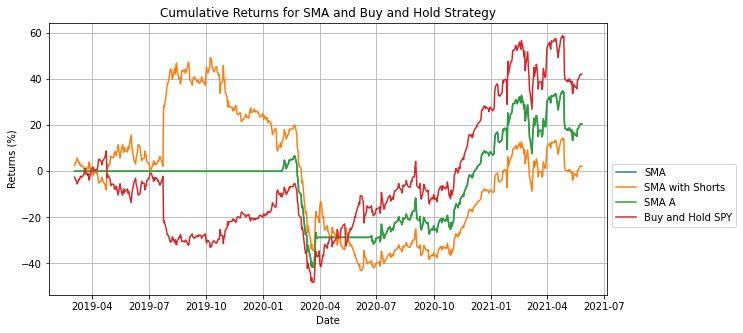

In [120]:
short_term_sma = 50
long_term_sma = 200

for symbol in topXPercent:
    ticker = symbol
    print(symbol)
    
    data = SMABacktest(ticker, short_term_sma, long_term_sma)
    stats_dict = getStratStats(data)
    df_stats = pd.DataFrame(stats_dict).round(3)
    
    df0 = pd.DataFrame(stats_dict)
    df0.columns = ['A', 'A Buy and Hold']
    df1 = pd.DataFrame(_stats)
    df1.columns = ['SMA', 'base_strat']
    #df2 = pd.DataFrame(_stats_shorts)
    #df2.columns = ['SMA with Shorts', 'Buy and Hold']
    df = pd.concat([df0, df1], axis=1)
    #df.drop('base_strat', axis=1, inplace=True)
    display(df.round(3))
    #display(df_stats)
    
    sma_safety_data_ = SMAMeanReversionSafety(ticker, SMA, threshold, shorts, end_date, end_date1)
    sma_safety_stats_dict = getStratStats(sma_safety_data_)
    sma_safety_df_stats_ = pd.DataFrame(sma_safety_stats_dict).round(3)
    
    df0 = pd.DataFrame(sma_safety_stats_dict)
    df0.columns = ['A', 'A Buy and Hold']
    df1 = pd.DataFrame(sma_safety_df_stats_)
    df1.columns = ['SMA', 'base_strat']
    #df2 = pd.DataFrame(_stats_shorts)
    #df2.columns = ['SMA with Shorts', 'Buy and Hold']
    df = pd.concat([df0, df1], axis=1)
    #df.drop('base_strat', axis=1, inplace=True)
    display(df.round(3))
    #display(sma_safety_stats_dict)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
    long = sma_safety_data_.loc[sma_safety_data_['position']==1]['Close']
    ax[0].plot(sma_safety_data_['Close'], label='Price', linestyle=':', color=colors[1])
    ax[0].plot(sma_safety_data_['SMA'], label='SMA', linestyle='--', color=colors[0])
    ax[0].scatter(long.index, long, label='Long', c=colors[2])
    ax[0].legend(bbox_to_anchor=[1, 0.75])
    ax[0].set_ylabel('Price ($)')
    ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
    ax[1].plot(sma_safety_data_['extension']*100, label='Extension', color=colors[0])
    ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
    ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
    ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
    ax[1].set_title('Price Extension and Buy/Sell Thresholds')
    ax[1].set_ylabel(f'Extension (%)')
    ax[1].legend(bbox_to_anchor=[1, 0.75])
    ax[2].plot(sma_safety_data_['position'])
    ax[2].set_xlabel('Date')
    ax[2].set_title('Position')
    ax[2].set_yticks([-1, 0, 1])
    ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
    plt.tight_layout()
    plt.show()    
    
    sma_data = SMABacktest(symbol, short_term_sma, long_term_sma, shorts=False)
    sma_data_stats_dict = getStratStats(sma_data)
    sma_data_df_stats = pd.DataFrame(sma_data_stats_dict).round(3)
    
    df0 = pd.DataFrame(sma_data_stats_dict)
    df0.columns = ['A', 'A Buy and Hold']
    df1 = pd.DataFrame(sma_data_df_stats)
    df1.columns = ['SMA', 'base_strat']
    #df2 = pd.DataFrame(_stats_shorts)
    #df2.columns = ['SMA with Shorts', 'Buy and Hold']
    df = pd.concat([df0, df1], axis=1)
    #df.drop('base_strat', axis=1, inplace=True)
    display(df.round(3))
    #display(sma_safety_stats_dict)
    #display(sma_data_df_stats)
    
    sma_data_shorts = SMABacktest(ticker, short_term_sma, long_term_sma, shorts=True)
    sma_data_shorts_stats_dict = getStratStats(sma_data_shorts)
    sma_data_shorts_df_stats = pd.DataFrame(sma_data_shorts_stats_dict).round(3)
    
    df0 = pd.DataFrame(sma_data_shorts_stats_dict)
    df0.columns = ['A', 'A Buy and Hold']
    df1 = pd.DataFrame(sma_data_shorts_df_stats)
    df1.columns = ['SMA', 'base_strat']
    df2 = pd.DataFrame(sma_data_shorts_df_stats)
    df2.columns = ['SMA with Shorts', 'Buy and Hold']
    df = pd.concat([df0, df1, df2], axis=1)
    #df.drop('base_strat', axis=1, inplace=True)
    display(df.round(3))
    #display(sma_data_shorts_df_stats)
    
    fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
    ax.plot((sma_data['strat_cum_returns'] - 1) * 100, \
        label='SMA')
    ax.plot((sma_data_shorts['strat_cum_returns'] - 1) * 100, \
        label='SMA with Shorts')
    ax.plot((data['strat_cum_returns'] - 1) * 100, \
        label='SMA A')
    ax.plot((sma_data['cum_returns'] - 1) * 100, \
        label='Buy and Hold SPY')
    ax.set_ylabel('Returns (%)')
    ax.set_xlabel('Date')
    ax.set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
    ax.legend(bbox_to_anchor=[1, 0.5])
    ax.grid()
    plt.show()
    
